# Probabilistic Programming 1: Introduction to Bayesian inference

#### Goal 
  - Familiarize yourself with basic concepts from Bayesian inference such as prior and posterior distributions.
  - Familiarize yourself with Jupyter notebooks and the basics of the Julia programming language.

#### Materials        
  - Mandatory
    - This notebook
    - Lecture notes on Probability Theory
    - Lecture notes on Bayesian Machine Learning
  - Optional
    - [Course installation guide](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/WKouw-Mar2020-JuliaJupyterInstallGuide.pdf)
    - [Jupyter notebook tutorial](https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook)
    - [Intro to programming in Julia](https://youtu.be/8h8rQyEpiZA?t=233).
    - [Differences between Julia and Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).
    - [Beer Tasting Experiment](https://journals.sagepub.com/doi/pdf/10.1177/1475725719848574)
    - [Savage-Dickey ratios](https://www.sciencedirect.com/science/article/pii/S0010028509000826?casa_token=AhA2bAAbOygAAAAA:3quBBzBv5PqTl0zdFo-_AKh2SmH_pH68FdXHMGGw0328wA1h0YGTdsOYkKwWBrwx84WVhselJA)

<!-- ## Bayesian inference -->

In 1937, one of the founders of the field of statistics, [Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher), published a story of how he explained _inference_ to a friend. This story, called the "Lady Tasting Tea", has been re-told many times in different forms. In this notebook, we will re-tell one of its modern variants and introduce you to some important concepts along the way. Note that none of the material used below is new; you have all heard this in the theory lectures. The point of the Probabilistic Programming sessions is to solve practical problems so that concepts from theory become less abstract and you develop an intuition for them.

---

First, let's get started with activating a Julia workspace and importing some modules.

In [8]:
using Pkg
Pkg.activate("../../../lessons/")
Pkg.instantiate();
IJulia.clear_output();

---
Every once in a while, a cell with "code notes" is added to explain Julia-specific commands, symbols or procedures. We expect students to be proficient in at least one programming language, preferably Python, C(++) or MATLAB (most closely related to Julia), and we will not expain generic programming constructs such as control flows and data structures.

Code notes:
- The code cell above activates a specific Julia workspace (a virtual environment) that lists all packages you will need for the Probabilistic Programming sessions. The first time you run this cell, it will download and install all packages automatically.

---

In [2]:
using Distributions
using Plots

---
Code notes:
- `using` is how you import libraries and modules in Julia. Here we have imported a library of probability distributions called [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) and a library of plotting utilities called [Plots.jl](https://github.com/JuliaPlots/Plots.jl).

In [10]:
?using

search: using SubString include_string unsafe_string unescape_string



```
using
```

`using Foo` will load the module or package `Foo` and make its [`export`](@ref)ed names available for direct use. Names can also be used via dot syntax (e.g. `Foo.foo` to access the name `foo`), whether they are `export`ed or not. See the [manual section about modules](@ref modules) for details.


---

## Beer Tasting Experiment

In the summer of 2017, students of the University of Amsterdam participated in a "Beer Tasting Experiment" ([Doorn et al., 2019](https://journals.sagepub.com/doi/pdf/10.1177/1475725719848574)). Each participant was given two cups and were told that the cups contained [Hefeweissbier](https://www.bierenco.nl/product/weihenstephaner-hefeweissbier/), one with alcohol and one without. The participants had to taste each beer and guess which of the two contained alcohol.

We are going to do a statistical analysis of the tasting experiment. We want to know to what degree participants are able to discriminate between the alcoholic and alcohol-free beers. The Bayesian approach is about 3 core steps: (1) specifying a model, (2) absorbing the data through inference (parameter estimation), and (3) evaluating the model. We are going to walk through these steps in detail below.

### 1. Model Specification

Model specification consists of two parts: a likelihood function and a prior distribution.

#### Likelihood

A [likelihood function](https://en.wikipedia.org/wiki/Likelihood_function) is a function of parameters given observed data. 

Here, we have an event variable $X$ that indicates that the choice was either "correct", which we will assign the number $1$, or "incorrect", which we will assign the number $0$. We can model this choice with what's known as a [_Bernoulli_ distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution). The Bernoulli distribution is a formula to compute the probability of a binary event. It has a "rate parameter" $\theta$, a number between $0$ and $1$, which governs the probability of the two events. If $\theta = 1$, then the participant will always choose the right cup ("always" = "with probability $1$") and if $\theta = 0$, then the participant will never choose the right cup ("never" = "with probability $0$"). Choosing at random, i.e. getting as many correct choices as incorrect choices, corresponds to $\theta = 0.5$.

As stated above, we are using the Bernoulli distribution in our tasting experiment. As the Bernoulli distribution's rate parameter $\theta$ increases, the event $X=1$, i.e. the participant correctly guesses the alcoholic beverage, becomes more probable. The formula for the Bernoulli distribution is:

$$\begin{align*}
p(X = x \mid \theta) =&\ \text{Bernoulli}(x \mid \theta) \\
=&\ \theta^x (1-\theta)^{1-x}
\end{align*}$$

If $X=1$, then the formula simplifies to $p(X = 1 \mid \theta) = \theta^1 (1-\theta)^{1-1} = \theta$. For $X=0$, it simplifies to $p(X = 0 \mid \theta) = \theta^0 (1-\theta)^{1-0} = 1-\theta$. If you have multiple _independent_ observations, e.g. a data set $\mathcal{D} = \{X_1, X_2, X_3\}$, you can get the probability of all observations by taking the product of individual probabilities:

$$p(\mathcal{D} \mid \theta) = \prod_{i=1}^{N} p(X_i \mid \theta)$$

As an example, suppose the first two participants have correctly guessed the beverage and a third one incorrectly guessed it. Then, the probability under $\theta = 0.8$ is $$p(\mathcal{D} = \{1,1,0\} \mid \theta = 0.8) = 0.8 \cdot 0.8 \cdot 0.2 = 0.128 \, .$$ 

That is larger than the probability under $\theta = 0.4$, which is 

$$p(\mathcal{D} = \{1,1,0\} \mid \theta = 0.4) = 0.4 \cdot 0.4 \cdot 0.6 = 0.096 \, .$$ 

But it is not as large as the probability under $\theta = 0.6$, which is 

$$p(\mathcal{D} = \{1,1,0\} \mid \theta = 0.6) = 0.6 \cdot 0.6 \cdot 0.4 = 0.144 \, .$$ 

As you can see, the likelihood function tells us how well each value of the parameter fits the observed data. In short, how "likely" each parameter value is.

#### Prior Distribution

In Bayesian inference, it is important to think about what kind of _prior knowledge_ you have about your problem. In our tasting experiment, this corresponds to what you think the probability is that a participant will correctly choose the cup. In other words, you have some thoughts about what value $\theta$ is in this scenario. You might think that the participants' choices are all going to be roughly random. Or, given that you have tasted other types of alcohol-free beers before, you might think that the participants are going to choose the right cup most of the time. This intuition, this "prior knowledge", needs to be quantified. We do that by specifying another probability distribution for it, in this case the [_Beta_ distribution](https://en.wikipedia.org/wiki/Beta_distribution):

$$\begin{align*} 
p(\theta) =&\ \text{Beta}(\theta \mid \alpha, \beta) \\
=&\ \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)}  \theta^{\alpha-1} (1-\theta)^{\beta-1} \, .
\end{align*}$$

We use a Beta distribution to describe our state of knowledge about appropriate values for $\theta$. 

The Beta distribution computes the probability of an outcome in the interval $[0,1]$. Like any other other distribution, it has parameters: $\alpha$ and $\beta$. Both are "shape parameters", meaning the distribution has a different shape for each value of the parameters. Let's visualise this!

In [3]:
x = [1 2 3;
     4 5 6]

2×3 Matrix{Int64}:
 1  2  3
 4  5  6

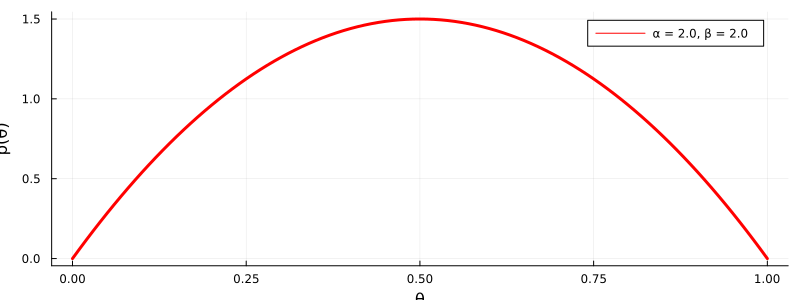

In [4]:
# Define shape parameters
α = 2.0
β = 2.0

# Define probability distribution
pθ = Beta(α, β)

# Define range of values for θ
θ = range(0.0, step=0.01, stop=1.0)

# Visualize probability distribution function
plot(θ, pdf.(pθ, θ), 
     linewidth=3, 
     color="red", 
     label="α = "*string(α)*", β = "*string(β), 
     xlabel="θ", 
     ylabel="p(θ)",
     size=(800,300))

Code notes:
- You can use greek letters as variables (write them like in latex, e.g. \alpha, and press `tab`)
- Ranges of numbers work just like they do in Matlab (e.g. `0.0:0.1:1.0`) and Python (e.g. `range(0.0, stop=100., length=100)`). Note that Julia is strict about types, e.g. using integers vs floats.
- There is a `.` after the command `pdf`. This refers to ["broadcasting"](https://julia.guide/broadcasting): the function is applied to each element of a list or array. Here we use the `pdf` command to compute the probability for each value of $\theta$ in the array.
- Many of the keyword arguments in the `plot` command should be familiar to you if you've worked with [Matplotlib](https://matplotlib.org/) (Python's plotting library).
- In the `label=` argument to plots, we have performed "string concatenation". In Julia, you write a string with double-quote characters and concatenate two strings by "multiplying", i.e. using `*`.

---

Note for the keen observers among you: since this is a continuous distribution, we are not actually plotting "probability", but rather ["probability density"](https://en.wikipedia.org/wiki/Probability_density_function#Link_between_discrete_and_continuous_distributions) (probability densities can be larger than $1$).

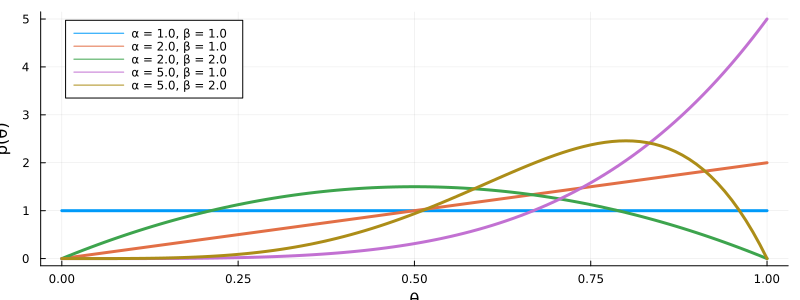

In [5]:
# Define shape parameters
α = [2.0, 5.0]
β = [1.0, 2.0]

# Define initial distribution
pθ = Beta(1.0, 1.0)

# Start initial plot
plot(θ, pdf.(pθ, θ), linewidth=3, label="α = 1.0, β = 1.0", xlabel="θ", ylabel="p(θ)", legend=:topleft)

# Loop over shape parameters
for a in α
    for b in β
        plot!(θ, pdf.(Beta(a, b), θ), linewidth=3, label="α = "*string(a)*", β = "*string(b))
    end
end
plot!(size=(800,300))

Code notes:
- Square brackets around numbers automatically creates an Array (in Python, they create lists).
- The `:` in `:topleft` indicates a `Symbol` type. It has many uses, but here it is used synonymously with a string option (e.g. legend="topleft").
- `for` loops can be done by using a range, such as `for i = 1:10` (like in Matlab), or using a variable that iteratively takes a value in an array, such as `for i in [1,2.3]` (like in Python). More [here](https://www.tutorialkart.com/julia/julia-for-loop/).
- The `!` at the end of the plot command means the function is performed ["in-place"](https://docs.julialang.org/en/v1/manual/style-guide/#bang-convention-1). In other words, it changes its input arguments. Here, we change the plot by adding lines.
- The final `plot!` is there to ensure Jupyter actually plots the figure. If you end a cell on an `end` command, Jupyter will remain silent.

---

As you can see, the Beta distribution is quite flexible and can capture your belief about how often participants will correctly detect the alcoholic beverage. For example, the purple line indicates that you believe that it is very probable that participants will always get it right (peak lies on $\theta=1.0$), but you still think there is some probability that the participants will guess at random ($p(\theta = 1/2) \approx 0.3$). The yellow-brown line indicates you believe that it is nearly impossible that the participants will always get it right ($p(\theta = 1) \approx 0.0$), but you still believe that they will get it right more often than not (peak lies around $\theta \approx 0.8$).

In summary: a prior distribution $p(\theta)$ reflects our beliefs about good values for parameter $\theta$ _before_ data is observed.

---

#### Exercise

I want you to pick values for the shape parameters $\alpha$ and $\beta$ that reflect how often you think the participants will get it right.

---

### 2. Parameter estimation

Now that we have specified our generative model, it is time to estimate unknown variables. We'll first look at the data and then the inference part.

#### Data

The data of the participants in Amsterdam is available online at the [Open Science Foundation](https://osf.io/428pb/?view_only=e3dc67dab9c54d23a92fb2e88465f428). We'll start by reading it in.

In [6]:
using DataFrames
using CSV

Code notes:
- [CSV.jl](https://github.com/JuliaData/CSV.jl) is a library for reading in data stored in tables.
- [DataFrames.jl](https://github.com/JuliaData/DataFrames.jl) manipulates table data (like `pandas` in Python).

In [7]:
# Read data from CSV file
data = DataFrame(CSV.File("../datasets/TastingBeerResults.csv"))

# Extract variable indicating correctness of guess
D = data[!, :CorrectIdentify];
println("D = ", D)

D = [1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]


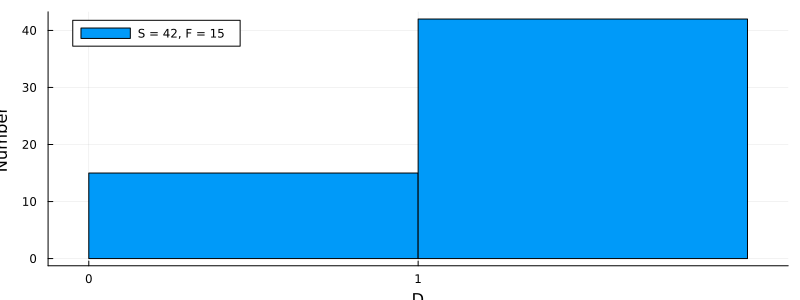

In [8]:
# Number of successes and failures
S = sum(D .== 1)
F = sum(D .== 0)

# Visualize frequencies
histogram(D, bins=[0,1,2], label="S = "*string(S)*", F = "*string(F), xlabel="D", xticks=[0,1], ylabel="Number", legend=:topleft, size=(800,300))

Code notes:
- The `!` in `data[!, ` is specific to the DataFrames syntax.
- The `.==` checks for each element of the array D whether it is equal.

Let's visualize the likelihood of these observations.

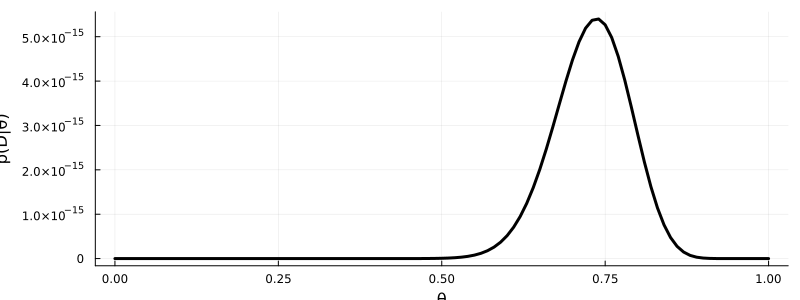

In [9]:
# Define the Bernoulli likelihood function
likelihood(θ) = prod([θ^X_i * (1-θ)^(1-X_i) for X_i in D])

# Plot likelihood
plot(θ, likelihood.(θ), linewidth=3, color="black", label="", xlabel="θ", ylabel="p(D|θ)", size=(800,300))

The likelihood has somewhat of a bell shape, peaking just below $\theta = 0.75$. Note that the y-axis is very small. Indeed, the likelihood is not a proper probability distribution, because it doesn't integrate / sum to $1$.

#### Inference

Using our generative model, we can estimate parameters for unknown variables. Remember Bayes' rule:

$$ p(\theta \mid \mathcal{D}) = \frac{p(\mathcal{D} \mid \theta) p(\theta)}{p(\mathcal{D})} \, .$$

The posterior $p(\theta \mid \mathcal{D})$ equals the likelihood $p(\mathcal{D} \mid \theta)$ times the prior $p(\theta)$ divided by the evidence $p(\mathcal{D})$. In our tasting experiment, we have a special thing going on: [conjugacy](https://en.wikipedia.org/wiki/Conjugate_prior). The Beta distribution is "conjugate" to the Bernoulli likelihood, meaning that the posterior distribution is also going to be a Beta distribution. Specifically with the Beta-Bernoulli combination, it is easy to see what conjugacy actually means. Recall the formula for the Beta distribution:

$$\begin{align*} 
p(\theta) =&\ \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)}  \theta^{\alpha-1} (1-\theta)^{\beta-1} \, .
\end{align*}$$

The term $\Gamma(\alpha + \beta) / \left( \Gamma(\alpha) \Gamma(\beta) \right)$ normalises this distribution. If you ignore that and multiply it with the likelihood, you get something that simplifies beautifully:

$$\begin{align*} 
p(\mathcal{D} \mid \theta) p(\theta) \ \propto&\ \ \prod_{i=1}^{N} \big[ \theta^{X_i} (1-\theta)^{1-X_i} \big] \cdot \theta^{\alpha-1} (1-\theta)^{\beta-1} \\
=&\ \ \theta^{\sum_{i=1}^{N} X_i} (1-\theta)^{\sum_{i=1}^{N} 1-X_i} \cdot \theta^{\alpha-1} (1-\theta)^{\beta-1} \\
=&\ \ \theta^{S} (1-\theta)^{F} \cdot \theta^{\alpha-1} (1-\theta)^{\beta-1} \\
=&\ \ \theta^{S + \alpha-1} (1-\theta)^{F + \beta-1} \, ,
\end{align*}$$

where $S = \sum_{i=1}^{N} X_i$ is the number of successes (correct guesses) and $F = \sum_{i=1}^{N} 1 - X_i$ is the number of failures (incorrect guesses). 

This last line is again the formula for the Beta distribution (except for a proper normalisation) but with different parameters ($S+\alpha$ instead of $\alpha$ and $F+\beta$ instead of $\beta$). This is what we mean by conjugacy: applying Bayes rule to a conjugate prior and likelihood pair yields a posterior distribution of the same family as the prior, which in this case is a Beta distribution.

Let's now visualise the posterior after observing the data from Amsterdam.

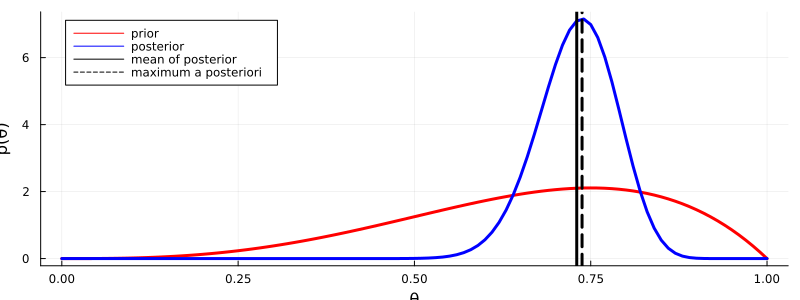

In [10]:
# Define shape parameters of prior distribution
α0 = 4.0
β0 = 2.0

# Define prior distribution
pθ = Beta(α0, β0)

# Update parameters for the posterior
αN = α0 + sum(D .== 1)
βN = β0 + sum(D .== 0)

# Define posterior distribution
pθD = Beta(αN, βN)

# Mean of posterior
mean_post = αN / (αN + βN)
mode_post = (αN - 1) / (αN + βN - 2)

# Visualize probability distribution function
plot(θ, pdf.(pθ, θ), linewidth=3, color="red", label="prior", xlabel="θ", ylabel="p(θ)")
plot!(θ, pdf.(pθD, θ), linewidth=3, color="blue", label="posterior", size=(800,300))
vline!([mean_post], color="black", linewidth=3, label="mean of posterior", legend=:topleft)
vline!([mode_post], color="black", linewidth=3, linestyle=:dash, label="maximum a posteriori", legend=:topleft)

Code notes:
- `vline` draw a vertical line in the plot, at the specified point on the x-axis.
- `mode()` extracts the [mode](https://en.wikipedia.org/wiki/Mode_(statistics)) of the supplied distribution, i.e. the point with the largest probability.

That looks great! We have updated our belief from a very broad prior to a much sharper posterior. 

The posterior contains a lot of information: it tells us something about every value for $\theta$. Sometimes, we are interested in a point estimate, i.e. the probability of a single value for $\theta$ under the posterior. Two well-known point estimators are the mean of the posterior and the mode (the value for $\theta$ with the highest probability). I have plotted both point estimates in the figure above. In this case, they are nearly equal. 

---

#### Exercise

Plug the shape parameters of your prior into a copy of the cell above and see how your posterior differs.

---

### 3. Model Evaluation

Given our model assumptions and a posterior for theta, we can now make quantitative predictions about how well we think people can recognize alcoholic from non-alcoholic hefeweizen. But suppose you meet someone else who is absolutely sure that people can't tell the difference. Can you say something about the probability of his belief, given the experiment?

Technically, this is a question about comparing the performance of different models. Model comparison is also known in the statistical literature as "hypothesis testing".

In hypothesis testing, you start with a null hypothesis $\mathcal{H}_0$, which is a particular choice for the detection parameter $\theta$. In the question above, the other person's belief corresponds to $\theta = 0.5$. We then have an alternative hypothesis $\mathcal{H}_1$, namely that his belief is wrong, i.e. $\theta \neq 0.5$. From a Bayesian perspective, hypothesis testing is just about comparing the posterior beliefs about these two hypotheses:

$$\begin{align*}
\underbrace{\frac{p(\mathcal{H}_1 | \mathcal{D})}{p(\mathcal{H}_0 | \mathcal{D})}}_{\text{Posterior belief over hypotheses}} = \underbrace{\frac{p(\mathcal{H}_1)}{p(\mathcal{H}_0)}}_{\text{Prior belief over hypotheses}} \times \underbrace{\frac{p(\mathcal{D} | \mathcal{H}_1)}{p(\mathcal{D} | \mathcal{H}_0)}}_{\text{Likelihood of hypotheses}} \, .
\end{align*}$$

Note that the evidence term $p(\mathcal{D})$ is missing, because it appears in the posterior for both hypotheses and therefore cancels out. The hypothesis likelihood ratio is also called the **Bayes factor**. Bayes factors can be hard to compute, but in some cases we can simplify it: if the null hypothesis is a specific value of interest, for instance $\theta = 0.5$, and the alternative hypothesis is not that specific value, e.g. $\theta \neq 0.5$, then the factor reduces to what's known as a Savage-Dickey Ratio (see Appendix A of [Wagemakers et al., 2010](https://www.sciencedirect.com/science/article/pii/S0010028509000826?casa_token=AhA2bAAbOygAAAAA:3quBBzBv5PqTl0zdFo-_AKh2SmH_pH68FdXHMGGw0328wA1h0YGTdsOYkKwWBrwx84WVhselJA)):

$$ \frac{p(\mathcal{D} | \mathcal{H}_1)}{p(\mathcal{D} | \mathcal{H}_0)} = \frac{p(\theta = 0.5)}{p(\theta = 0.5 \mid \mathcal{D})} \, .$$

This compares the probability of $\theta = 0.5$ under the prior versus $\theta = 0.5$ under the posterior. It effectively tells you how much your belief changes after observing the data. Let's compute the Savage-Dickey ratio for our experiment:

In [11]:
BF_10 = pdf(pθ, 0.5) / pdf(pθD, 0.5)
println("The Bayes factor for H1 versus H0 = "*string(BF_10))

The Bayes factor for H1 versus H0 = 229.23178145896927


So, in the experiment, the alternative hypothesis _"students can discriminate alcoholic from non-alcoholic Hefeweissbier"_ is more than 200 times more probable than the null hypothesis that _"students cannot discriminate alcoholic from non-alcoholic Hefeweissbier"_.


#### Exercise

Compute the Bayes factor for your prior and posterior distribution. How many times is the alternative hypothesis more probable than the null hypothesis?

---